### 1. Loading Data

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from pathlib import Path

RAW_XLSX = Path("../data/raw/dataset.xlsx")
RAW_CSV = Path("../data/raw/dataset.xlsx - All.csv")
OUT_PATH = Path("../data/processed/01_cleaned_data.csv")
FIG_DIR = Path("../figures")
OUT_PATH.parent.mkdir(parents=True, exist_ok=True)
FIG_DIR.mkdir(parents=True, exist_ok=True)

if RAW_CSV.exists():
    df = pd.read_csv(RAW_CSV)
else:
    df = pd.read_excel(RAW_XLSX)

# Normalize column names
df.columns = (
    df.columns.str.replace("\xa0", " ", regex=False)
    .str.replace(r"\s+", " ", regex=True)
    .str.strip()
)

if "Patient ID" not in df.columns:
    raise KeyError("'Patient ID' column is required.")

# Convert non-ID columns to numeric
non_id_cols = [c for c in df.columns if c != "Patient ID"]
df[non_id_cols] = df[non_id_cols].apply(pd.to_numeric, errors="coerce")

raw_df = df.copy()

### 2. Data Integrity Check

In [48]:
check_cols = ["Hemoglobin", "Leukocytes", "Platelets"]
missing_cols = [c for c in check_cols if c not in df.columns]
if missing_cols:
    raise KeyError(f"Missing expected columns: {missing_cols}")

print(df[check_cols].describe())

means = df[check_cols].mean()
stds = df[check_cols].std(ddof=0)

mean_ok = (means.abs() < 0.1).all()
std_ok = ((stds - 1).abs() < 0.1).all()

if mean_ok and std_ok:
    print(
        "Confirmed empirically: source features appear pre standardized (approx mean 0, std 1). "
        "Values represent z scores rather than absolute units."
    )
else:
    print(
        "Not confirmed empirically: source data does not appear fully standardized. "
        "Proceeding with re-standardization."
    )

         Hemoglobin    Leukocytes     Platelets
count  6.030000e+02  6.020000e+02  6.020000e+02
mean  -1.601319e-08  6.215833e-09 -3.535004e-10
std    1.000830e+00  1.000832e+00  1.000832e+00
min   -4.345603e+00 -2.020303e+00 -2.552426e+00
25%   -5.862439e-01 -6.372547e-01 -6.053457e-01
50%    4.031596e-02 -2.128790e-01 -1.217160e-01
75%    7.295320e-01  4.542955e-01  5.314981e-01
max    2.671868e+00  4.522042e+00  9.532034e+00
Confirmed empirically: source features appear pre standardized (approx mean 0, std 1). Values represent z scores rather than absolute units.


### 3. Threshold Sensitivity Analysis

In [49]:
target_cols = [
    "SARS-Cov-2 exam result",
    "Patient addmited to regular ward (1=yes, 0=no)",
    "Patient addmited to semi-intensive unit (1=yes, 0=no)",
    "Patient addmited to intensive care unit (1=yes, 0=no)",
]

exclude_cols = {
    "Patient ID",
    "SARS-Cov-2 exam result",
    "Patient age quantile",
    "Patient addmited to regular ward (1=yes, 0=no)",
    "Patient addmited to semi-intensive unit (1=yes, 0=no)",
    "Patient addmited to intensive care unit (1=yes, 0=no)",
}

candidate_cols = [
    c
    for c in raw_df.columns
    if c not in exclude_cols and pd.api.types.is_numeric_dtype(raw_df[c])
]

patient_counts = raw_df[candidate_cols].notna().sum(axis=1)

exact_8 = int((patient_counts == 8).sum())
exact_9 = int((patient_counts == 9).sum())
ge_10 = int((patient_counts >= 10).sum())

print(f"Patients with exactly 8 non-missing lab features: {exact_8}")
print(f"Patients with exactly 9 non-missing lab features: {exact_9}")
print(f"Patients with >= 10 non-missing lab features: {ge_10}")

if exact_8 == 0 and exact_9 == 0:
    print("Threshold sanity check: counts of non-missing lab features per patient show almost no patients with 8-9 available values, supporting the cutoff at 10.")
else:
    print("Sanity check supports cutoff at 10 non-missing lab features per patient.")

Patients with exactly 8 non-missing lab features: 0
Patients with exactly 9 non-missing lab features: 0
Patients with >= 10 non-missing lab features: 603
Threshold sanity check: counts of non-missing lab features per patient show almost no patients with 8-9 available values, supporting the cutoff at 10.


### 4. Cohort Selection (N=603)

In [50]:
df = raw_df.loc[patient_counts >= 10].copy()

### 5. Feature Definition (Separating Features from Labels)

In [51]:
exclude_feature_cols = {
    "Patient ID",
    "SARS-Cov-2 exam result",
    "Patient age quantile",
    "Patient addmited to regular ward (1=yes, 0=no)",
    "Patient addmited to semi-intensive unit (1=yes, 0=no)",
    "Patient addmited to intensive care unit (1=yes, 0=no)",
}

lab_feature_cols = [
    c
    for c in df.columns
    if c not in exclude_feature_cols and pd.api.types.is_numeric_dtype(df[c])
]

### 6. Cleaning & Imputation
We removed lab features with more than 90 percent missing values.

We assessed missingness threshold sensitivity at 0.80 versus 0.90. With k=4, 0.90 retained 45 features and yielded a higher silhouette (~0.469) than 0.304, so we selected 0.90.

In [52]:
MISSINGNESS_THRESHOLD = 0.90

missing_frac = df[lab_feature_cols].isna().mean()
kept_lab_features = missing_frac[missing_frac < MISSINGNESS_THRESHOLD].index.tolist()

imputer = SimpleImputer(strategy="median")
imputed = imputer.fit_transform(df[kept_lab_features])
imputed_df = pd.DataFrame(imputed, columns=kept_lab_features, index=df.index)

### 7. Re-Standardization for Selected Cohort

In [53]:
# Note: Although source data is Z-scored, we re-standardize after filtering
# to align the cohort to exact mean 0 and std 1 before PCA and clustering.
scaler = StandardScaler()
scaled = scaler.fit_transform(imputed_df)

processed = df.copy()
processed[kept_lab_features] = scaled

### 8. Visualization & Export

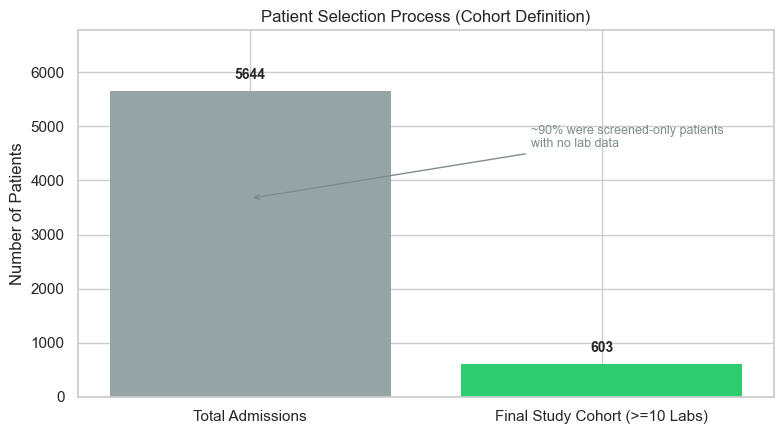

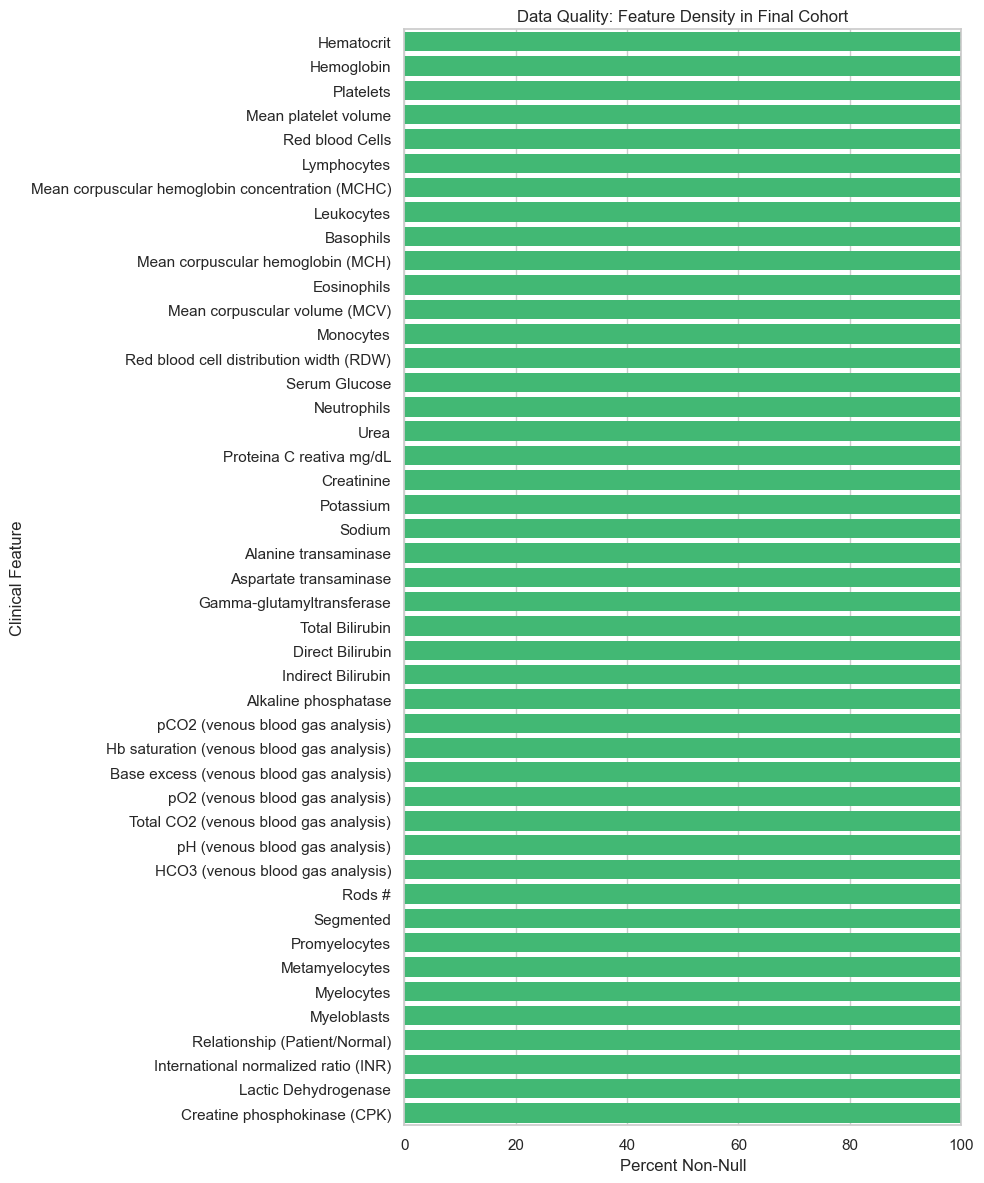

Saved cleaned data with shape: (603, 111)


In [54]:
# Patient selection funnel
total_admissions = raw_df.shape[0]
final_cohort = processed.shape[0]

cohort_labels = [
    "Total Admissions",
    "Final Study Cohort (>=10 Labs)",
]
cohort_values = [total_admissions, final_cohort]
cohort_colors = ["#95a5a6", "#2ecc71"]

plt.figure(figsize=(8, 4.5))
ax = plt.bar(cohort_labels, cohort_values, color=cohort_colors, edgecolor="none")
plt.title("Patient Selection Process (Cohort Definition)")
plt.ylabel("Number of Patients")
plt.ylim(0, max(cohort_values) * 1.2)

for bar, value in zip(ax, cohort_values):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + max(cohort_values) * 0.03,
        f"{value}",
        ha="center",
        va="bottom",
        fontsize=10,
        fontweight="bold",
    )

plt.annotate(
    "~90% were screened-only patients\nwith no lab data",
    xy=(0, cohort_values[0] * 0.65),
    xytext=(0.8, cohort_values[0] * 0.85),
    textcoords="data",
    arrowprops={"arrowstyle": "->", "color": "#7f8c8d"},
    ha="left",
    va="center",
    fontsize=9,
    color="#7f8c8d",
)

plt.tight_layout()
plt.savefig(FIG_DIR / "cohort_selection_funnel.png", dpi=300)
plt.show()

# Data density plot (final cohort)
completeness = processed[kept_lab_features].notna().mean().mul(100).sort_values()

sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 12))
ax = sns.barplot(
    x=completeness.values,
    y=completeness.index,
    color="#2ecc71",
    edgecolor="none",
)
ax.axvline(100, color="black", linestyle="--", linewidth=1)
ax.set_xlim(0, 100)
ax.set_xlabel("Percent Non-Null")
ax.set_ylabel("Clinical Feature")
ax.set_title("Data Quality: Feature Density in Final Cohort")
plt.tight_layout()
plt.savefig(FIG_DIR / "data_quality_feature_density.png", dpi=300)
plt.show()

# Save processed data
processed.to_csv(OUT_PATH, index=False)
print(f"Saved cleaned data with shape: {processed.shape}")